# Data Preprocessing Notebook

In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import json
from utilities import aggregate_timeseries_vectorized

## 0 Load file

---

This is the input file, the only "moving" part.

In [ ]:
import xarray as xr
ds = xr.open_dataset("data/in_updatable/albo_alpine_ML_Standardised_MeanSpatPred.nc")
# ds # Inspect dataset
ds

<xarray.Dataset> Size: 2MB
Dimensions:       (longitude: 151, latitude: 76, Z1: 52)
Coordinates:
  * longitude     (longitude) float64 1kB 2.15 2.25 2.35 ... 16.95 17.05 17.15
  * latitude      (latitude) float64 608B 50.55 50.45 50.35 ... 43.15 43.05
  * Z1            (Z1) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    Std_alboeggs  (Z1, latitude, longitude) float32 2MB ...
    crs           int32 4B ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.8-54)
    created_date:  2026-01-30 15:23:04

In [3]:
ds = xr.open_dataset("data/in_updatable/albo_alpine_ML_Standardised_MeanSpatPred_backup.nc")
# ds # Inspect dataset
ds

<xarray.Dataset> Size: 2MB
Dimensions:       (longitude: 151, latitude: 76, time: 52)
Coordinates:
  * longitude     (longitude) float64 1kB 2.15 2.25 2.35 ... 16.95 17.05 17.15
  * latitude      (latitude) float64 608B 50.55 50.45 50.35 ... 43.15 43.05
  * time          (time) datetime64[ns] 416B 2025-01-04 ... 2025-12-26
Data variables:
    Std_alboeggs  (time, latitude, longitude) float32 2MB ...
    crs           int32 4B ...
Attributes:
    Conventions:   CF-1.4
    created_by:    R packages ncdf4 and terra (version 1.8-54)
    created_date:  2026-01-30 15:23:04

---

# 1 Convert and save file 

In [10]:
crs = "EPSG:4326"
da = ds["Std_alboeggs"]  # dims: (Z1, latitude, longitude)

lons = ds["longitude"].values
lats = ds["latitude"].values

lon_edges = np.concatenate([
    [lons[0] - (lons[1] - lons[0]) / 2],
    (lons[:-1] + lons[1:]) / 2,
    [lons[-1] + (lons[-1] - lons[-2]) / 2]
])
lat_edges = np.concatenate([
    [lats[0] - (lats[0] - lats[1]) / 2],
    (lats[:-1] + lats[1:]) / 2,
    [lats[-1] + (lats[-2] - lats[-1]) / 2]
])

polygons, timeseries, names = [], [], []
cell_id = 0

for lat_i, lat in enumerate(lats):
    for lon_i, lon in enumerate(lons):
        cell_id += 1
        poly = Polygon([
            (lon_edges[lon_i],   lat_edges[lat_i]),
            (lon_edges[lon_i+1], lat_edges[lat_i]),
            (lon_edges[lon_i+1], lat_edges[lat_i+1]),
            (lon_edges[lon_i],   lat_edges[lat_i+1])
        ])

        # Timeseries for this cell
        series = da[:, lat_i, lon_i].values
        ts_dict = {str(int(z)): (None if np.isnan(v) else float(v)) 
                   for z, v in zip(ds["Z1"].values, series)}

        # Only keep if at least one value is not None
        if any(v is not None for v in ts_dict.values()):
            polygons.append(poly)
            names.append(f"Cell {cell_id}")
            timeseries.append(ts_dict)

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"timeseries": timeseries, "geometry": polygons, "name": names},
    crs=crs
)

import hashlib
from shapely.geometry.polygon import orient
from shapely import set_precision

def make_numeric_hash(geom):
    geom = orient(geom, sign=1.0)              # normalize orientation
    geom = set_precision(geom, grid_size=1e-6) # round coordinates
    geom_bytes = geom.wkb                      # binary form
    hash_val = int(hashlib.md5(geom_bytes).hexdigest(), 16)
    return str(hash_val % 10**10).zfill(10)


gdf["name"] = gdf["geometry"].apply(make_numeric_hash)

print(f"✅ Final GDF has {len(gdf)} cells (filtered)")

#############################################
# add study area boolean flag for limited version 
study_area_extent = gpd.read_parquet("../data_processing/data/in/study_area_extent_trentino.parquet")
if gdf.crs != study_area_extent.crs:
    study_area_extent = study_area_extent.to_crs(gdf.crs)
clip_geom = study_area_extent.union_all() 
gdf["study_area_extent_trentino"] = gdf.intersects(clip_geom)
#############################################

gdf.to_file("../public/data/out/model_output_trentino_2025.fgb")
gdf

# should run in a few seconds!

✅ Final GDF has 4298 cells (filtered)


,timeseries,geometry,name,study_area_extent_trentino
0,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((10.1 50.5, 10.2 50.5, 10.2 50.5, 10....",3550552707,False
1,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((10 50.5, 10.1 50.5, 10.1 50.4, 10 50...",8076462264,False
2,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((10.1 50.5, 10.2 50.5, 10.2 50.4, 10....",0847597813,False
3,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((10.2 50.5, 10.3 50.5, 10.3 50.4, 10....",0434557179,False
4,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((10.3 50.5, 10.4 50.5, 10.4 50.4, 10....",8734924133,False
...,...,...,...,...
4293,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((5.9 43.2, 6 43.2, 6 43.1, 5.9 43.1, ...",6797562166,False
4294,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((6 43.2, 6.1 43.2, 6.1 43.1, 6 43.1, ...",8782957222,False
4295,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((6.1 43.2, 6.2 43.2, 6.2 43.1, 6.1 43...",8278282023,False
4296,"{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","POLYGON ((6.2 43.2, 6.3 43.2, 6.3 43.1, 6.2 43...",7852132529,False


## 2 NUTS3 processing

In [11]:
nuts = gpd.read_file("data/in/EU_NUTS3_01M.fgb")

nuts = aggregate_timeseries_vectorized(
    source_gdf=gdf, 
    target_gdf=nuts, 
    target_id_col='NUTS_ID', # <-- Specify the unique ID column here
    timeseries_col='timeseries'
)

nuts["name"] = nuts["NAME_LATN"]
nuts = nuts[["geometry","timeseries", "name"]]
#nuts = nuts[nuts["timeseries"].notnull()]

###########################################################
# quick fix as there are not enough data avilable for other nuts3 regions, delete everything but Trento
#nuts.loc[nuts["name"] != "Trento", "timeseries"] = None
###########################################################
nuts["study_area_extent_trentino"] = False
nuts.loc[nuts.name == "Trento", "study_area_extent_trentino"] = True

nuts.to_file("../public/data/out/EU_NUTS3_01M_2025.fgb")

nuts

# should run in a few seconds!

Projecting to EPSG:3035 for accurate area calculation...
Performing vectorized spatial overlay...
Calculating weights and grouping results...
Merging results back to target GeoDataFrame...


/Users/dome/work/fem/_webapp_build/data_processing/utilities.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_series = intersection_gdf.groupby(target_id_col).apply(calculate_weighted_ts)


,geometry,timeseries,name,study_area_extent_trentino
0,"MULTIPOLYGON (((55.45045 -20.87215, 55.45956 -...",NaN,La Réunion,False
1,"MULTIPOLYGON (((45.28707 -12.80172, 45.28277 -...",NaN,Mayotte,False
2,"MULTIPOLYGON (((27.42946 43.60027, 27.43941 43...",NaN,Varna,False
3,"MULTIPOLYGON (((27.9503 43.95771, 27.95419 43....",NaN,Dobrich,False
4,"MULTIPOLYGON (((27.07789 44.1336, 27.08425 44....",NaN,Silistra,False
...,...,...,...,...
864,"MULTIPOLYGON (((9.26104 39.91453, 9.27525 39.9...",NaN,Sud Sardegna,False
865,"MULTIPOLYGON (((-3.98862 48.72653, -3.98377 48...",NaN,Finistère,False
866,"MULTIPOLYGON (((-61.07318 16.30264, -61.09606 ...",NaN,Guadeloupe,False
867,"MULTIPOLYGON (((-61.05728 14.83477, -61.05045 ...",NaN,Martinique,False


## 3 Comuni processing

In [12]:
comuni = gpd.read_file("data/in/IT_comuni.fgb")
# dissolving by COMUNE name probably not a good idea as there are actual correct duplicates. If the data were correct, this code could be used
# comuni = comuni.dissolve(by="COMUNE").reset_index()
# instead, just using a unique id here 

comuni["unique_id"] = comuni.index + 1 # Create a unique ID column if not present

comuni = aggregate_timeseries_vectorized(
    source_gdf=gdf, 
    target_gdf=comuni, 
    target_id_col='unique_id', # <-- Specify the unique ID column here
    timeseries_col='timeseries'
)

del comuni["unique_id"]
comuni["name"] = comuni["COMUNE"]
del comuni["COMUNE"]

comuni["study_area_extent_trentino"] = comuni.intersects(clip_geom)
comuni.to_file("../public/data/out/IT_comuni_2025.fgb")

comuni.loc[comuni['timeseries'].notna()].head()

Projecting to EPSG:3035 for accurate area calculation...
Performing vectorized spatial overlay...
Calculating weights and grouping results...
Merging results back to target GeoDataFrame...


/Users/dome/work/fem/_webapp_build/data_processing/utilities.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_series = intersection_gdf.groupby(target_id_col).apply(calculate_weighted_ts)


,geometry,timeseries,name,study_area_extent_trentino
1662,"MULTIPOLYGON (((13.736 45.76158, 13.73589 45.7...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...",Sgonico-Zgonik,False
1663,"MULTIPOLYGON (((13.83371 45.70724, 13.83406 45...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...",Monrupino-Repentabor,False
1664,"MULTIPOLYGON (((13.75819 45.66314, 13.75823 45...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...",Trieste,False
1665,"MULTIPOLYGON (((13.59629 45.80794, 13.60331 45...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...",Duino Aurisina-Devin Nabrežina,False
1666,"MULTIPOLYGON (((13.53509 45.81664, 13.53705 45...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...",Monfalcone,False


<Axes: >

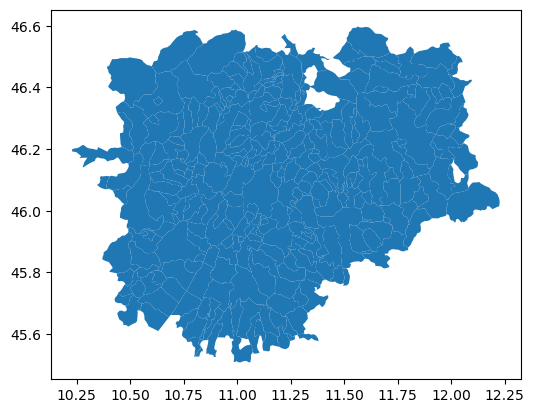

In [13]:
comuni.loc[comuni['study_area_extent_trentino'] == True].plot()

<Axes: >

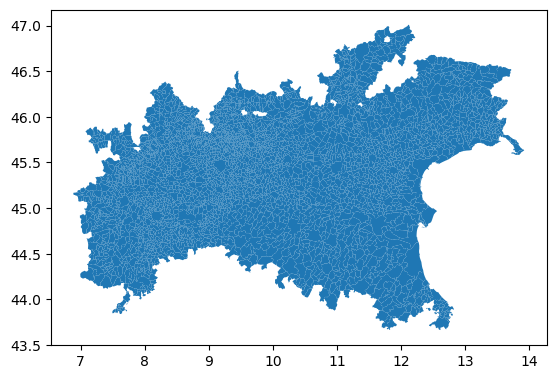

In [14]:
comuni.loc[comuni['timeseries'].notna()].plot()